# The Security Characteristic Line

The Security Characteristic Line (SCL) is a graphical representation that illustrates the relationship between the excess returns of a security and the excess returns of the market portfolio. It is used in finance to assess the performance of a security relative to the market.

In this notebook I plot the SCL and report alphas, betas, R-squared and firm-specific volatility for different stocks. You can change the list of tickers to compute the same results for the stocks of your choice.

## Getting the Data

I'll start by importing the libraries required to download the data. I use `pandas` for data manipulation and time series operations, `yfinance` for downloading stock prices and Treasury rates, and `warnings` to suppress non-critical FutureWarnings.

You can modify the ticker list or date range in the subsequent cells to analyze different securities or time periods.

In [1]:
import pandas as pd
import yfinance as yf

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

tickers = ['C', 'NVDA', 'SPY', 'BLK', 'TSLA', 'GE', 'BA']

start_date = '2015-08-31'
end_date = '2025-09-30'

I start by downloading data and computing monthly returns for different stocks. The analysis covers the period from August 2015 to September 2025, using monthly data to reduce noise while maintaining sufficient observations for statistical analysis.

First, I'll download closing prices for a diversified set of stocks including financial (C, BLK), technology (NVDA, TSLA), industrial (GE, BA), and market benchmark (SPY) securities. The data is resampled to month-end frequency and converted to monthly returns.

In [2]:
df = (
    yf.download(
        tickers=tickers,
        progress=False,
        start=start_date,
        end=end_date,
    )
    .loc[:, 'Close']
    .resample('ME')
    .last()
    .pct_change()
    .dropna()
)


Next, I download the risk-free rate using the 3-month Treasury bill rate (^IRX) and convert it to a monthly rate to match our return frequency.

In [3]:
rf = (
    yf.download(
        tickers=['^IRX'],
        start='2020-09-01',
        end='2025-09-30',
        progress=False,
    )
    .loc[:, 'Close']
    .resample("ME")
    .last()
    .dropna()
    .assign(RF=lambda x: x['^IRX'] / 12 / 100)
    .drop(columns=['^IRX'])
)

Finally, I calculate excess returns by subtracting the risk-free rate from each security's returns. 

In [4]:
excess_returns = df.sub(rf['RF'], axis=0).dropna()

Now, the idea is to create a panel dataset of stacked excess returns for each ticker in one column, and the excess returns of the SPY in another column. I first start by detaching 'SPY' to a different dataset and renaming the excess returns of SPY over the risk-free rate as RMRF.

In [5]:
spy = (
    df.loc[:, ['SPY']]
    .rename(columns={'SPY': 'RMRF'})
    .reset_index()
    .rename_axis(columns=None)
)
spy

,Date,RMRF
0,2015-09-30,-0.025516
1,2015-10-31,0.085060
2,2015-11-30,0.003655
3,2015-12-31,-0.017283
4,2016-01-31,-0.049787
...,...,...
116,2025-05-31,0.062845
117,2025-06-30,0.051386
118,2025-07-31,0.023032
119,2025-08-31,0.020520


I then stack all other excess returns in panel form and rename the column with excess returns RETRF. Note that I delete SPY first.

In [6]:
stacked = (
    excess_returns.drop(columns="SPY")
    .reset_index()
    .melt(id_vars='Date', var_name='Ticker', value_name='RETRF')
)
stacked

,Date,Ticker,RETRF
0,2020-09-30,BA,-0.038250
1,2020-10-31,BA,-0.126355
2,2020-11-30,BA,0.459249
3,2020-12-31,BA,0.015844
4,2021-01-31,BA,-0.092864
...,...,...,...
361,2025-05-31,TSLA,0.224358
362,2025-06-30,TSLA,-0.086618
363,2025-07-31,TSLA,-0.033089
364,2025-08-31,TSLA,0.079675


I finally merge `spy` with the `stacked` dataframe so that every stock excess returns can be matched with the corresponding market excess returns.

In [7]:
panel = stacked.merge(spy, on='Date', how='left')
panel

,Date,Ticker,RETRF,RMRF
0,2020-09-30,BA,-0.038250,-0.037444
1,2020-10-31,BA,-0.126355,-0.024933
2,2020-11-30,BA,0.459249,0.108777
3,2020-12-31,BA,0.015844,0.037049
4,2021-01-31,BA,-0.092864,-0.010191
...,...,...,...,...
361,2025-05-31,TSLA,0.224358,0.062845
362,2025-06-30,TSLA,-0.086618,0.051386
363,2025-07-31,TSLA,-0.033089,0.023032
364,2025-08-31,TSLA,0.079675,0.020520


## A Single Regression

I now proceed to import the libraries needed to analyze the excess returns. I will use `statsmodels` (formula API) for running OLS regressions with robust standard errors, `describe` from `statsmodels.stats.descriptivestats` to quickly describe the data, and `seaborn` for creating the Security Characteristic Line visualizations.

In [8]:
import statsmodels.formula.api as smf
from statsmodels.stats.descriptivestats import describe
import seaborn as sns
from matplotlib.ticker import PercentFormatter

I will start analyzing just a single ticker, in this case General Electric (GE).

In [9]:
single_ticker = panel[panel['Ticker'] == 'GE']
single_ticker

,Date,Ticker,RETRF,RMRF
183,2020-09-30,GE,-0.015797,-0.037444
184,2020-10-31,GE,0.190942,-0.024933
185,2020-11-30,GE,0.371906,0.108777
186,2020-12-31,GE,0.061826,0.037049
187,2021-01-31,GE,-0.011151,-0.010191
...,...,...,...,...
239,2025-05-31,GE,0.216628,0.062845
240,2025-06-30,GE,0.043192,0.051386
241,2025-07-31,GE,0.051196,0.023032
242,2025-08-31,GE,0.011829,0.020520


We can quickly compute the average and standard deviation of monthly excess returns for both GE and SPY. We can see that the average monthly excess return for GE has almost quadrupled the average monthly excess return of SPY, but has more than twice more volatility.

In [10]:
stats = 100 * describe(data=single_ticker, stats=['mean', 'std'])
stats.index = ['Mean (%)', 'St. Dev. (%)']
stats.round({'RETRF': 3, 'RMRF': 3})

,RETRF,RMRF
Mean (%),4.005,1.284
St. Dev. (%),10.283,4.580


The package `statsmodels` has a formula API mode that allows us to run regressions like in R. To specify a regression such that
$$
  \text{RETRF} = \alpha + \beta \text{RMRF} + e,
$$
we just need to specify `RETRF ~ RMRF`. Standard errors are computed by controlling for heteroscedasticity. The results show that the CAPM alpha of GE is positive and statistically significant at the 5% level.

In [11]:
res = smf.ols(formula='RETRF ~ RMRF', data=single_ticker).fit(cov_type='HC1')
print(res.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  RETRF   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.425
No. Observations:                  61   F-statistic:                     35.08
Covariance Type:                  HC1   Prob (F-statistic):           1.74e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0211      0.010      2.112      0.035       0.002       0.041
RMRF           1.4796      0.250      5.923      0.000       0.990       1.969

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)


Finally, we can plot the regression line using the funciton `lmplot` from the package `seaborn`. In the plot the dependent variable is the excess return of the stock and the independent variable is the excess return of the market. Note that I am formatting both axes to display numbers are percent by using the function `PercentFormatter` from `matplotlib.ticker`.

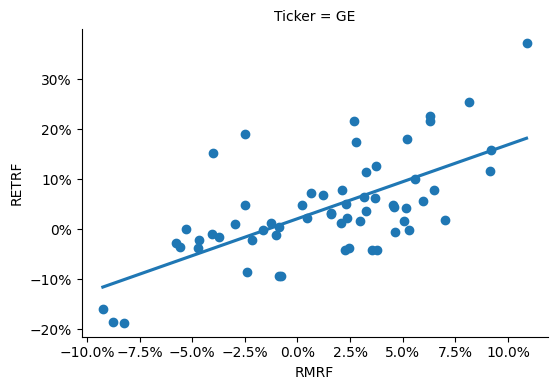

In [12]:
ax = sns.lmplot(
    data=single_ticker,
    x='RMRF',
    y='RETRF',
    col='Ticker',
    hue='Ticker',
    col_wrap=2,
    ci=None,
    scatter_kws={'alpha': 1},
    height=4,
    aspect=1.3,
)

for axes in ax.axes.flat:
    axes.xaxis.set_major_formatter(PercentFormatter(1.0))
    axes.yaxis.set_major_formatter(PercentFormatter(1.0))

## Running Multiple Regressions

The advantage of having the data stored in panel form is that with `seaborn` we can plot different regression lines for each stock using the same code as before without any modifications.

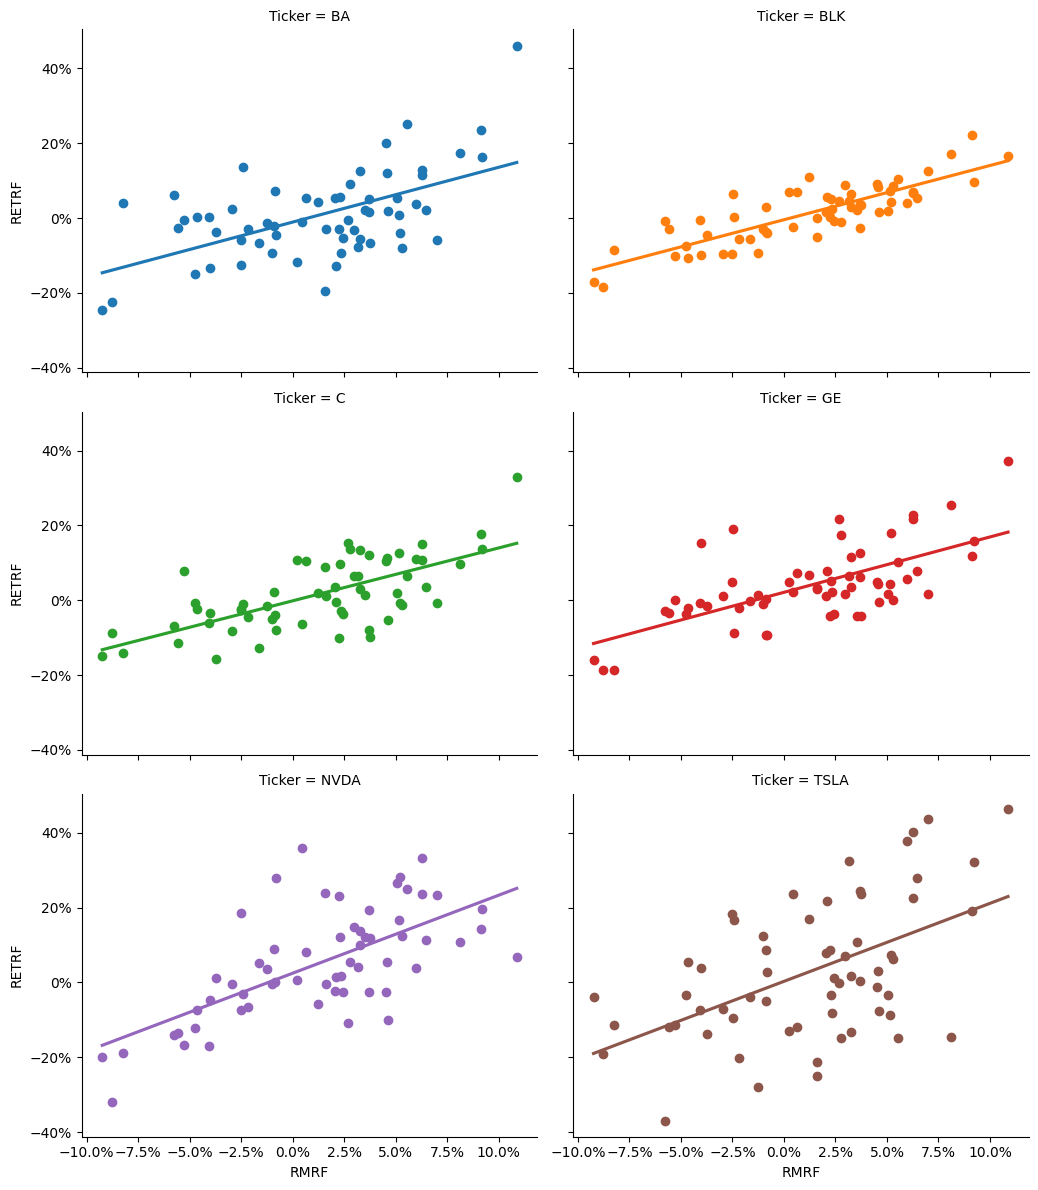

In [13]:
ax = sns.lmplot(
    data=panel,
    x='RMRF',
    y='RETRF',
    col='Ticker',
    hue='Ticker',
    col_wrap=2,
    ci=None,
    scatter_kws={'alpha': 1},
    height=4,
    aspect=1.3,
)

for axes in ax.axes.flat:
    axes.xaxis.set_major_formatter(PercentFormatter(1.0))
    axes.yaxis.set_major_formatter(PercentFormatter(1.0))

Finally, I generate a table with the regression results including alpha, beta, R-squared, and firm-specific volatility for each stock. I first define the function `regress` that takes as an input a dataframe, runs the CAPM regression, and generates a dataframe with several statistics from the regression.

In [14]:
def regress(data):
    res = smf.ols(formula='RETRF ~ RMRF', data=data).fit(cov_type='HC1')
    return pd.Series(
        data=[
            res.params['Intercept'],
            res.pvalues['Intercept'],
            res.params['RMRF'],
            res.rsquared,
            res.resid.std() * (12**0.5) * 100,
        ],
        index=[
            ('Alpha', 'Estimate'),
            ('Alpha', 'P-value'),
            ('Beta', ''),
            ('R-Squared', ''),
            ('Residual Std', 'Annual (%)'),
        ],
    )

I can then apply the function `regress` to the panel data by iterating over each ticker. Using the method `apply` is `pandas` is a very convenient way of doing this.

In [15]:
results = panel.groupby('Ticker').apply(regress, include_groups=False)
results.index.name = None
results.columns = pd.MultiIndex.from_tuples(results.columns)
results = results.round(
    {
        ('Alpha', 'Estimate'): 4,
        ('Alpha', 'P-value'): 3,
        ('Beta', ''): 3,
        ('R-Squared', ''): 3,
        ('Residual Std', 'Annual (%)'): 2,
    }
)
results

Alpha           Beta R-Squared Residual Std
     Estimate P-value                    Annual (%)
BA    -0.0109   0.379  1.465     0.323        33.69
BLK   -0.0047   0.445  1.450     0.697        15.16
C     -0.0017   0.847  1.414     0.461        24.28
GE     0.0211   0.035  1.480     0.434        26.79
NVDA   0.0245   0.078  2.085     0.437        37.53
TSLA   0.0028   0.885  2.085     0.269        54.48